# CIFAR-10

CIFAR-10 dataset: http://www.cs.toronto.edu/~kriz/cifar.html

#### Cieľ zadania: Klasifikácia obrázku jednej z nasledujúcich tried:
• 0: airplane\
• 1: automobile\
• 2: bird\
• 3: cat\
• 4: deer\
• 5: dog\
• 6: frog\
• 7: horse\
• 8: ship\
• 9: truck

In [2]:
from matplotlib import pyplot
from keras.datasets import cifar10

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import wandb
from wandb.keras import WandbCallback

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Add

In [3]:
def countValues(data):
    unique_vals, counts = np.unique(data, return_counts=True)

    for val, count in zip(unique_vals, counts):
        print("Class {}: {} records".format(val, count))

In [4]:
def dataNormalisation(data):
    return data.astype('float32') / 255.0

In [5]:
dataClass = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]

In [6]:
(X_train, y_train), (X_val, y_val) = cifar10.load_data()

print('Train dataset:\n X=%s\n y=%s\n' % (X_train.shape, y_train.shape))
print('Validation dataset:\n X=%s\n y=%s' % (X_val.shape, y_val.shape))

Train dataset:
 X=(50000, 32, 32, 3)
 y=(50000, 1)

Validation dataset:
 X=(10000, 32, 32, 3)
 y=(10000, 1)


In [7]:
countValues(y_train)

Class 0: 5000 records
Class 1: 5000 records
Class 2: 5000 records
Class 3: 5000 records
Class 4: 5000 records
Class 5: 5000 records
Class 6: 5000 records
Class 7: 5000 records
Class 8: 5000 records
Class 9: 5000 records


In [8]:
countValues(y_val)

Class 0: 1000 records
Class 1: 1000 records
Class 2: 1000 records
Class 3: 1000 records
Class 4: 1000 records
Class 5: 1000 records
Class 6: 1000 records
Class 7: 1000 records
Class 8: 1000 records
Class 9: 1000 records


Normalizacia dat do intervalu 0 - 1

In [9]:
X_train = dataNormalisation(X_train)
X_val = dataNormalisation(X_val)

X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=25)

In [10]:
countValues(y_val)

Class 0: 497 records
Class 1: 482 records
Class 2: 507 records
Class 3: 504 records
Class 4: 500 records
Class 5: 511 records
Class 6: 494 records
Class 7: 507 records
Class 8: 494 records
Class 9: 504 records


In [11]:
countValues(y_test)

Class 0: 503 records
Class 1: 518 records
Class 2: 493 records
Class 3: 496 records
Class 4: 500 records
Class 5: 489 records
Class 6: 506 records
Class 7: 493 records
Class 8: 506 records
Class 9: 496 records


### Dáta:
• RGB obrázky v rozmeroch 32x32x3\
• obrázky rozdelené do 10 tried

Trénovacích vzoriek: 50000 - každá trieda má 5000 vzoriek\
Validačných vzoriek: 10000 - každá trieda má 1000 vzoriek\
&emsp;&emsp;&emsp;    • validačný dataset - 5000 vzoriek\
&emsp;&emsp;&emsp;    • testovací dataset - 5000 vzoriek

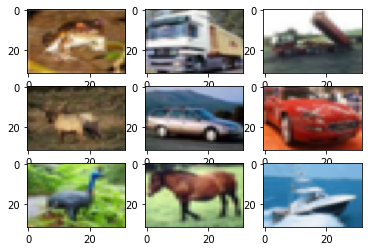

In [12]:
for i in range(9):
    plt.subplot(331 + i)
    plt.imshow(X_train[i], aspect='auto')
plt.show()

In [13]:
print('Class:')
for i in range(9):
    print(y_train[i], '-', dataClass[y_train[i][0]])

Class:
[6] - frog
[9] - truck
[9] - truck
[4] - deer
[1] - automobile
[1] - automobile
[2] - bird
[7] - horse
[8] - ship


In [14]:
# one hot encoding
y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)
y_test = tf.keras.utils.to_categorical(y_test)

In [15]:
print(y_train[1])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


# Models

- adaptivny learning rate
- minimalna hranica learning rate-u (0.000001)
- early stopping
- pocet epoch 20
- batch size 32, obcas 64

## Pokus 1

__Test accuracy: 0.7266__\
__Test loss: 1.692__

In [15]:
wandb.init(project="neural-network-assgiment2")
wandb.run.name = "Pokus 1"
config = wandb.config
config.learning_rate = 0.001
config.batch_size = 32
config.epochs = 20

model = keras.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(10, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=0.000001)

history = model.fit(X_train, y_train, epochs=config.epochs, batch_size=config.batch_size, validation_data=(X_val, y_val), callbacks=[lr_scheduler,early_stop,WandbCallback()])

# Evaluate the model
val_loss, val_acc = model.evaluate(X_test, y_test, verbose=2)
print('Test accuracy:', val_acc)
print('Test loss:', val_loss)

# Evaluate the model on the val set and log the results
wandb.log({'Test loss': val_loss, 'Test accuracy': val_acc})

wandb: Currently logged in as: andrejbelak0 (neural-netwok-nn). Use `wandb login --relogin` to force relogin


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/20
1563/1563 [==============================] - ETA: 0s - loss: 1.3254 - accuracy: 0.5263

INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230411_234146-q1lovgfh\files\model-best\assets


INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230411_234146-q1lovgfh\files\model-best\assets
wandb: Adding directory to artifact (D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230411_234146-q1lovgfh\files\model-best)... Done. 0.0s


1563/1563 [==============================] - 36s 23ms/step - loss: 1.3254 - accuracy: 0.5263 - val_loss: 1.0753 - val_accuracy: 0.6298 - lr: 0.0010
Epoch 2/20
1563/1563 [==============================] - ETA: 0s - loss: 0.9567 - accuracy: 0.6658

INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230411_234146-q1lovgfh\files\model-best\assets


INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230411_234146-q1lovgfh\files\model-best\assets
wandb: Adding directory to artifact (D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230411_234146-q1lovgfh\files\model-best)... Done. 0.0s


1563/1563 [==============================] - 34s 22ms/step - loss: 0.9567 - accuracy: 0.6658 - val_loss: 0.9738 - val_accuracy: 0.6712 - lr: 0.0010
Epoch 3/20
1561/1563 [============================>.] - ETA: 0s - loss: 0.7839 - accuracy: 0.7262

INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230411_234146-q1lovgfh\files\model-best\assets


INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230411_234146-q1lovgfh\files\model-best\assets
wandb: Adding directory to artifact (D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230411_234146-q1lovgfh\files\model-best)... Done. 0.0s


1563/1563 [==============================] - 33s 21ms/step - loss: 0.7838 - accuracy: 0.7262 - val_loss: 0.8857 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 4/20
1563/1563 [==============================] - 32s 21ms/step - loss: 0.6341 - accuracy: 0.7784 - val_loss: 0.8903 - val_accuracy: 0.7084 - lr: 0.0010
Epoch 5/20
1563/1563 [==============================] - 33s 21ms/step - loss: 0.5051 - accuracy: 0.8233 - val_loss: 0.9224 - val_accuracy: 0.7128 - lr: 0.0010
Epoch 6/20
1563/1563 [==============================] - 33s 21ms/step - loss: 0.3794 - accuracy: 0.8684 - val_loss: 0.9714 - val_accuracy: 0.7196 - lr: 0.0010
Epoch 7/20
1563/1563 [==============================] - 33s 21ms/step - loss: 0.2716 - accuracy: 0.9068 - val_loss: 1.0497 - val_accuracy: 0.7224 - lr: 0.0010
Epoch 8/20
1563/1563 [==============================] - 34s 22ms/step - loss: 0.1937 - accuracy: 0.9345 - val_loss: 1.2452 - val_accuracy: 0.7086 - lr: 0.0010
Epoch 9/20
1563/1563 [==============================] - 3

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 512)               1

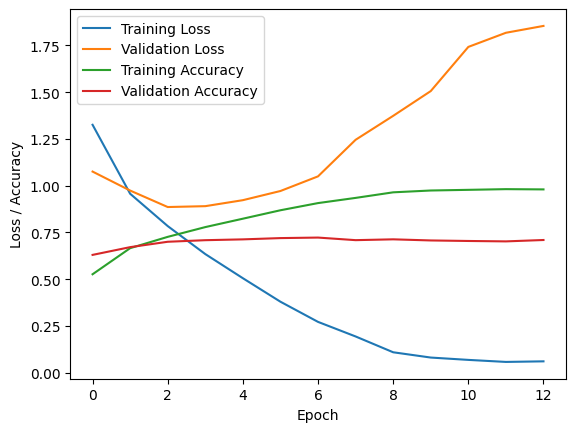

In [17]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()

## Pokus 2

- znizeny pocet vstupov pre dense layer

__Test accuracy: 0.7028__\
__Test loss: 1.028__

In [18]:
wandb.init(project="neural-network-assgiment2")
wandb.run.name = "Pokus 2"
config = wandb.config
config.learning_rate = 0.001
config.batch_size = 32
config.epochs = 20


model = keras.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=0.000001)

history = model.fit(X_train, y_train, epochs=config.epochs, batch_size=config.batch_size, validation_data=(X_val, y_val), callbacks=[lr_scheduler,early_stop,WandbCallback()])

# Evaluate the model
val_loss, val_acc = model.evaluate(X_test, y_test, verbose=2)
print('Test accuracy:', val_acc)
print('Test loss:', val_loss)

# Evaluate the model on the val set and log the results
wandb.log({'Test loss': val_loss, 'Test accuracy': val_acc})

Test accuracy,▁
Test loss,▁
accuracy,▁▃▄▅▆▆▇▇█████
epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
loss,█▆▅▄▃▃▂▂▁▁▁▁▁
lr,████████▁▁▁▁▁
val_accuracy,▁▄▆▇▇██▇▇▇▇▆▇
val_loss,▂▂▁▁▁▂▂▄▅▅▇██
Test accuracy,0.7266
Test loss,1.69171
accuracy,0.97996


Epoch 1/20
1562/1563 [============================>.] - ETA: 0s - loss: 1.4818 - accuracy: 0.4608

INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230411_234911-dykhlofm\files\model-best\assets


INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230411_234911-dykhlofm\files\model-best\assets
wandb: Adding directory to artifact (D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230411_234911-dykhlofm\files\model-best)... Done. 0.0s


1563/1563 [==============================] - 22s 14ms/step - loss: 1.4817 - accuracy: 0.4609 - val_loss: 1.2656 - val_accuracy: 0.5496 - lr: 0.0010
Epoch 2/20
1563/1563 [==============================] - ETA: 0s - loss: 1.1298 - accuracy: 0.6000

INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230411_234911-dykhlofm\files\model-best\assets


INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230411_234911-dykhlofm\files\model-best\assets
wandb: Adding directory to artifact (D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230411_234911-dykhlofm\files\model-best)... Done. 0.0s


1563/1563 [==============================] - 22s 14ms/step - loss: 1.1298 - accuracy: 0.6000 - val_loss: 1.0864 - val_accuracy: 0.6160 - lr: 0.0010
Epoch 3/20
1559/1563 [============================>.] - ETA: 0s - loss: 0.9973 - accuracy: 0.6515

INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230411_234911-dykhlofm\files\model-best\assets


INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230411_234911-dykhlofm\files\model-best\assets
wandb: Adding directory to artifact (D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230411_234911-dykhlofm\files\model-best)... Done. 0.0s


1563/1563 [==============================] - 23s 15ms/step - loss: 0.9972 - accuracy: 0.6516 - val_loss: 0.9985 - val_accuracy: 0.6504 - lr: 0.0010
Epoch 4/20
1562/1563 [============================>.] - ETA: 0s - loss: 0.9159 - accuracy: 0.6824

INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230411_234911-dykhlofm\files\model-best\assets


INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230411_234911-dykhlofm\files\model-best\assets
wandb: Adding directory to artifact (D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230411_234911-dykhlofm\files\model-best)... Done. 0.0s


1563/1563 [==============================] - 23s 14ms/step - loss: 0.9158 - accuracy: 0.6824 - val_loss: 0.9770 - val_accuracy: 0.6612 - lr: 0.0010
Epoch 5/20
1560/1563 [============================>.] - ETA: 0s - loss: 0.8502 - accuracy: 0.7058

INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230411_234911-dykhlofm\files\model-best\assets


INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230411_234911-dykhlofm\files\model-best\assets
wandb: Adding directory to artifact (D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230411_234911-dykhlofm\files\model-best)... Done. 0.0s


1563/1563 [==============================] - 24s 15ms/step - loss: 0.8504 - accuracy: 0.7058 - val_loss: 0.9304 - val_accuracy: 0.6728 - lr: 0.0010
Epoch 6/20
1563/1563 [==============================] - 23s 15ms/step - loss: 0.7972 - accuracy: 0.7228 - val_loss: 0.9628 - val_accuracy: 0.6664 - lr: 0.0010
Epoch 7/20
1559/1563 [============================>.] - ETA: 0s - loss: 0.7535 - accuracy: 0.7395

INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230411_234911-dykhlofm\files\model-best\assets


INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230411_234911-dykhlofm\files\model-best\assets
wandb: Adding directory to artifact (D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230411_234911-dykhlofm\files\model-best)... Done. 0.0s


1563/1563 [==============================] - 23s 15ms/step - loss: 0.7536 - accuracy: 0.7396 - val_loss: 0.9167 - val_accuracy: 0.6902 - lr: 0.0010
Epoch 8/20
1563/1563 [==============================] - 21s 13ms/step - loss: 0.7128 - accuracy: 0.7505 - val_loss: 0.9731 - val_accuracy: 0.6732 - lr: 0.0010
Epoch 9/20
1563/1563 [==============================] - 22s 14ms/step - loss: 0.6705 - accuracy: 0.7662 - val_loss: 0.9365 - val_accuracy: 0.6882 - lr: 0.0010
Epoch 10/20
1563/1563 [==============================] - 22s 14ms/step - loss: 0.6359 - accuracy: 0.7777 - val_loss: 0.9186 - val_accuracy: 0.6960 - lr: 0.0010
Epoch 11/20
1563/1563 [==============================] - 22s 14ms/step - loss: 0.6056 - accuracy: 0.7874 - val_loss: 0.9287 - val_accuracy: 0.6932 - lr: 0.0010
Epoch 12/20
1563/1563 [==============================] - 22s 14ms/step - loss: 0.5702 - accuracy: 0.8008 - val_loss: 0.9971 - val_accuracy: 0.6802 - lr: 0.0010
Epoch 13/20
1563/1563 [==============================]

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 2304)              0         
                                                                 
 dense_2 (Dense)             (None, 64)               

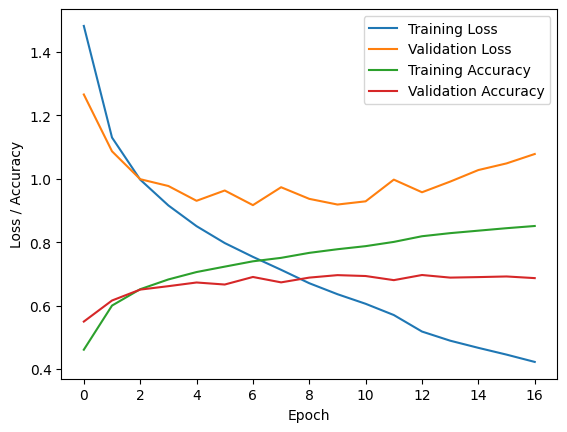

In [20]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()

## Pokus 3

- pridana dalsia konvolucna vrstva
- zvyseny batch size
- uprava vstupov pre dense layer
- pridany stride po poslednej konvolucnej vrstve

__Test accuracy: 0.7402__\
__Test loss: 1.832__

In [21]:
wandb.init(project="neural-network-assgiment2")
wandb.run.name = "Pokus 3"
config = wandb.config
config.learning_rate = 0.001
config.batch_size = 64
config.epochs = 20


model = keras.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, (3, 3), strides=(2,2), activation='relu', padding='same'),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(10, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=0.000001)

history = model.fit(X_train, y_train, epochs=config.epochs, batch_size=config.batch_size, validation_data=(X_val, y_val), callbacks=[lr_scheduler,early_stop,WandbCallback()])

# Evaluate the model
val_loss, val_acc = model.evaluate(X_test, y_test, verbose=2)
print('Test accuracy:', val_acc)
print('Test loss:', val_loss)

# Evaluate the model on the val set and log the results
wandb.log({'Test loss': val_loss, 'Test accuracy': val_acc})

Epoch 1/20
781/782 [============================>.] - ETA: 0s - loss: 1.3521 - accuracy: 0.5153

INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_145838-v5lq1n7h\files\model-best\assets


INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_145838-v5lq1n7h\files\model-best\assets
wandb: Adding directory to artifact (D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_145838-v5lq1n7h\files\model-best)... Done. 0.1s


782/782 [==============================] - 75s 94ms/step - loss: 1.3520 - accuracy: 0.5153 - val_loss: 1.0572 - val_accuracy: 0.6286 - lr: 0.0010
Epoch 2/20
781/782 [============================>.] - ETA: 0s - loss: 0.8902 - accuracy: 0.6879

INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_145838-v5lq1n7h\files\model-best\assets


INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_145838-v5lq1n7h\files\model-best\assets
wandb: Adding directory to artifact (D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_145838-v5lq1n7h\files\model-best)... Done. 0.1s


782/782 [==============================] - 56s 72ms/step - loss: 0.8901 - accuracy: 0.6879 - val_loss: 0.8616 - val_accuracy: 0.7034 - lr: 0.0010
Epoch 3/20
781/782 [============================>.] - ETA: 0s - loss: 0.6889 - accuracy: 0.7617

INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_145838-v5lq1n7h\files\model-best\assets


INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_145838-v5lq1n7h\files\model-best\assets
wandb: Adding directory to artifact (D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_145838-v5lq1n7h\files\model-best)... Done. 0.1s


782/782 [==============================] - 57s 73ms/step - loss: 0.6887 - accuracy: 0.7617 - val_loss: 0.8089 - val_accuracy: 0.7224 - lr: 0.0010
Epoch 4/20
781/782 [============================>.] - ETA: 0s - loss: 0.5356 - accuracy: 0.8134

INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_145838-v5lq1n7h\files\model-best\assets


INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_145838-v5lq1n7h\files\model-best\assets
wandb: Adding directory to artifact (D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_145838-v5lq1n7h\files\model-best)... Done. 0.1s


782/782 [==============================] - 57s 74ms/step - loss: 0.5356 - accuracy: 0.8134 - val_loss: 0.7855 - val_accuracy: 0.7326 - lr: 0.0010
Epoch 5/20
782/782 [==============================] - 57s 73ms/step - loss: 0.3875 - accuracy: 0.8649 - val_loss: 0.8527 - val_accuracy: 0.7302 - lr: 0.0010
Epoch 6/20
782/782 [==============================] - 56s 72ms/step - loss: 0.2631 - accuracy: 0.9077 - val_loss: 0.9862 - val_accuracy: 0.7278 - lr: 0.0010
Epoch 7/20
782/782 [==============================] - 55s 70ms/step - loss: 0.1718 - accuracy: 0.9404 - val_loss: 1.1945 - val_accuracy: 0.7168 - lr: 0.0010
Epoch 8/20
782/782 [==============================] - 55s 70ms/step - loss: 0.1110 - accuracy: 0.9620 - val_loss: 1.3940 - val_accuracy: 0.7136 - lr: 0.0010
Epoch 9/20
782/782 [==============================] - 56s 71ms/step - loss: 0.0935 - accuracy: 0.9676 - val_loss: 1.4767 - val_accuracy: 0.7270 - lr: 0.0010
Epoch 10/20
782/782 [==============================] - 56s 72ms/step 

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 conv2d_12 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 7, 7, 128)         73856     
                                                                 
 flatten_1 (Flatten)         (None, 6272)              0         
                                                                 
 dense_3 (Dense)             (None, 256)               1605888   
                                                      

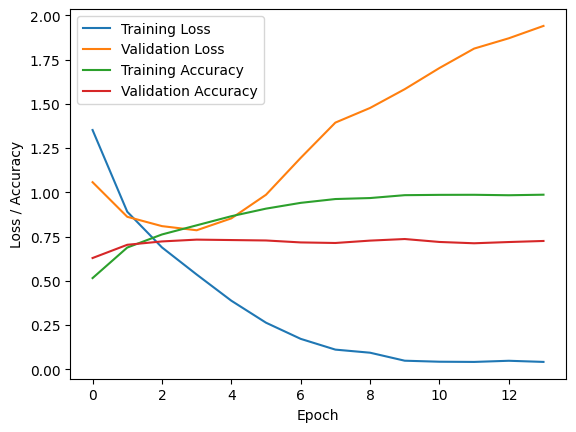

In [23]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()

## Pokus 4

- pridana BatchNormalization

__Test accuracy: 0.7074__\
__Test loss: 1.384__

In [24]:
wandb.init(project="neural-network-assgiment2")
wandb.run.name = "Pokus 4"
config = wandb.config
config.learning_rate = 0.001
config.batch_size = 32
config.epochs = 20


model = keras.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(10, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=0.000001)

history = model.fit(X_train, y_train, epochs=config.epochs, batch_size=config.batch_size, validation_data=(X_val, y_val), callbacks=[lr_scheduler,early_stop,WandbCallback()])

# Evaluate the model
val_loss, val_acc = model.evaluate(X_test, y_test, verbose=2)
print('Test accuracy:', val_acc)
print('Test loss:', val_loss)

# Evaluate the model on the val set and log the results
wandb.log({'Test loss': val_loss, 'Test accuracy': val_acc})

Test accuracy,▁
Test loss,▁
accuracy,▁▄▅▅▆▇▇███████
epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
loss,█▆▄▄▃▂▂▁▁▁▁▁▁▁
lr,█████████▁▁▁▁▁
val_accuracy,▁▆▇██▇▇▇▇█▇▆▇▇
val_loss,▃▁▁▁▁▂▃▅▅▆▇▇██
Test accuracy,0.7402
Test loss,1.83221
accuracy,0.98648


Epoch 1/20
1561/1563 [============================>.] - ETA: 0s - loss: 1.3036 - accuracy: 0.5559

INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_151222-fp6gs1t5\files\model-best\assets


INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_151222-fp6gs1t5\files\model-best\assets
wandb: Adding directory to artifact (D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_151222-fp6gs1t5\files\model-best)... Done. 0.0s


1563/1563 [==============================] - 50s 31ms/step - loss: 1.3035 - accuracy: 0.5559 - val_loss: 1.0962 - val_accuracy: 0.6108 - lr: 0.0010
Epoch 2/20
1563/1563 [==============================] - 46s 30ms/step - loss: 0.9113 - accuracy: 0.6812 - val_loss: 1.2485 - val_accuracy: 0.5844 - lr: 0.0010
Epoch 3/20
1561/1563 [============================>.] - ETA: 0s - loss: 0.7403 - accuracy: 0.7407

INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_151222-fp6gs1t5\files\model-best\assets


INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_151222-fp6gs1t5\files\model-best\assets
wandb: Adding directory to artifact (D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_151222-fp6gs1t5\files\model-best)... Done. 0.0s


1563/1563 [==============================] - 49s 31ms/step - loss: 0.7405 - accuracy: 0.7407 - val_loss: 0.9381 - val_accuracy: 0.6798 - lr: 0.0010
Epoch 4/20
1563/1563 [==============================] - 47s 30ms/step - loss: 0.5998 - accuracy: 0.7900 - val_loss: 1.1117 - val_accuracy: 0.6452 - lr: 0.0010
Epoch 5/20
1563/1563 [==============================] - 46s 30ms/step - loss: 0.4760 - accuracy: 0.8331 - val_loss: 1.3296 - val_accuracy: 0.6126 - lr: 0.0010
Epoch 6/20
1563/1563 [==============================] - 46s 30ms/step - loss: 0.3744 - accuracy: 0.8703 - val_loss: 1.1119 - val_accuracy: 0.6786 - lr: 0.0010
Epoch 7/20
1563/1563 [==============================] - 46s 30ms/step - loss: 0.2958 - accuracy: 0.8970 - val_loss: 1.1584 - val_accuracy: 0.6754 - lr: 0.0010
Epoch 8/20
1563/1563 [==============================] - 47s 30ms/step - loss: 0.2476 - accuracy: 0.9138 - val_loss: 1.8087 - val_accuracy: 0.5876 - lr: 0.0010
Epoch 9/20
1563/1563 [==============================] - 4

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 batch_normalization_4 (Batc  (None, 30, 30, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_5 (Batc  (None, 15, 15, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_15 (Conv2D)          (None, 13, 13, 64)        18496     
                                                      

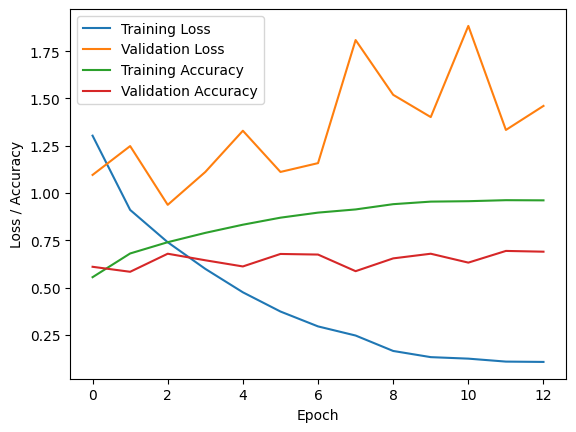

In [26]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()

## Pokus 5

- viac konvolucnych vrstiev za sebou
- dropout
- zvyseny kernel_size na poslednych konvolucnych vrstvach
- viac dense vrstiev
- zmena aktivacnej funkcue na LeakyReLU

__Test accuracy: 0.8086__\
__Test loss: 0.5782__

In [27]:
wandb.init(project="neural-network-assgiment2")
wandb.run.name = "Pokus 5"
config = wandb.config
config.learning_rate = 0.001
config.batch_size = 32
config.epochs = 20


model = keras.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='LeakyReLU', input_shape=(32, 32, 3)),
    layers.Conv2D(32, kernel_size=(3, 3), activation='LeakyReLU'),
    layers.BatchNormalization(),
    
    layers.Conv2D(64, kernel_size=(3, 3), activation='LeakyReLU'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Conv2D(128, kernel_size=(5, 5), activation='LeakyReLU'),
    layers.Conv2D(128, kernel_size=(5, 5), strides=(2, 2), activation='LeakyReLU'),
    layers.BatchNormalization(),
    
    layers.Flatten(),
    layers.Dense(256, activation='LeakyReLU'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='LeakyReLU'),
    layers.Dense(10, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=0.000001)

history = model.fit(X_train, y_train, epochs=config.epochs, batch_size=config.batch_size, validation_data=(X_val, y_val), callbacks=[lr_scheduler,early_stop,WandbCallback()])

# Evaluate the model
val_loss, val_acc = model.evaluate(X_test, y_test, verbose=2)
print('Test accuracy:', val_acc)
print('Test loss:', val_loss)

# Evaluate the model on the val set and log the results
wandb.log({'Test loss': val_loss, 'Test accuracy': val_acc})

Test accuracy,▁
Test loss,▁
accuracy,▁▃▄▅▆▆▇▇█████
epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
loss,█▆▅▄▃▃▂▂▁▁▁▁▁
lr,████████▁▁▁▁▁
val_accuracy,▃▁▇▅▃▇▇▁▅▇▄██
val_loss,▂▃▁▂▄▂▃▇▅▄█▄▅
Test accuracy,0.7074
Test loss,1.38419
accuracy,0.96182


Epoch 1/20
1562/1563 [============================>.] - ETA: 0s - loss: 1.5435 - accuracy: 0.4637

INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_152250-crjiahm9\files\model-best\assets


INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_152250-crjiahm9\files\model-best\assets
wandb: Adding directory to artifact (D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_152250-crjiahm9\files\model-best)... Done. 0.0s


1563/1563 [==============================] - 122s 77ms/step - loss: 1.5434 - accuracy: 0.4637 - val_loss: 1.2048 - val_accuracy: 0.5626 - lr: 0.0010
Epoch 2/20
1562/1563 [============================>.] - ETA: 0s - loss: 1.1141 - accuracy: 0.6074

INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_152250-crjiahm9\files\model-best\assets


INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_152250-crjiahm9\files\model-best\assets
wandb: Adding directory to artifact (D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_152250-crjiahm9\files\model-best)... Done. 0.0s


1563/1563 [==============================] - 130s 83ms/step - loss: 1.1140 - accuracy: 0.6074 - val_loss: 0.9820 - val_accuracy: 0.6462 - lr: 0.0010
Epoch 3/20
 266/1563 [====>.........................] - ETA: 1:40 - loss: 1.0168 - accuracy: 0.6472

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_3 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 26, 26, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 13, 13, 64)      

In [29]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()

## Pokus 6

- pridane rezidualne blocky

__Test accuracy: 0.8444__\
__Test loss: 0.5287__

- viac epoch

__Test accuracy: 0.8422__\
__Test loss: 0.5959__

In [15]:
wandb.init(project="neural-network-assgiment2")
wandb.run.name = "Pokus 6"
config = wandb.config
config.learning_rate = 0.001
config.batch_size = 64
config.epochs = 20


def resnet_block(input_data, filters, conv_size):
    x = layers.Conv2D(filters, conv_size, activation='LeakyReLU', padding='same')(input_data)
    x = layers.Conv2D(filters, conv_size, activation='LeakyReLU', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, input_data])
    x = layers.Activation('LeakyReLU')(x)
    return x

input_layer = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, kernel_size=(3, 3), activation='LeakyReLU')(input_layer)
x = layers.Conv2D(32, kernel_size=(3, 3), activation='LeakyReLU')(x)
x = layers.BatchNormalization()(x)

x = resnet_block(x, filters=32, conv_size=(3, 3))
x = resnet_block(x, filters=32, conv_size=(3, 3))

x = layers.Conv2D(64, kernel_size=(3, 3), activation='LeakyReLU')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.25)(x)

x = resnet_block(x, filters=64, conv_size=(5, 5))

x = layers.Conv2D(128, kernel_size=(5, 5), activation='LeakyReLU')(x)
x = layers.Conv2D(128, kernel_size=(5, 5), strides=(2, 2), activation='LeakyReLU')(x)
x = layers.BatchNormalization()(x)

x = layers.Flatten()(x)
x = layers.Dense(256, activation='LeakyReLU')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='LeakyReLU')(x)
output_layer = layers.Dense(10, activation='softmax')(x)

model = keras.Model(inputs=input_layer, outputs=output_layer)

optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=0.000001)

history = model.fit(X_train, y_train, epochs=config.epochs, batch_size=config.batch_size, validation_data=(X_val, y_val), callbacks=[lr_scheduler,early_stop,WandbCallback()])

# Evaluate the model
val_loss, val_acc = model.evaluate(X_test, y_test, verbose=2)
print('Test accuracy:', val_acc)
print('Test loss:', val_loss)

# Evaluate the model on the val set and log the results
wandb.log({'Test loss': val_loss, 'Test accuracy': val_acc})


wandb: Currently logged in as: andrejbelak0 (neural-netwok-nn). Use `wandb login --relogin` to force relogin


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/20
251/782 [========>.....................] - ETA: 2:55 - loss: 1.9637 - accuracy: 0.3390

KeyboardInterrupt: 

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_10 (Conv2D)             (None, 30, 30, 32)   896         ['input_1[0][0]']                
                                                                                                  
 conv2d_11 (Conv2D)             (None, 28, 28, 32)   9248        ['conv2d_10[0][0]']              
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 28, 28, 32)  128         ['conv2d_11[0][0]']              
 rmalization)                                                                                 

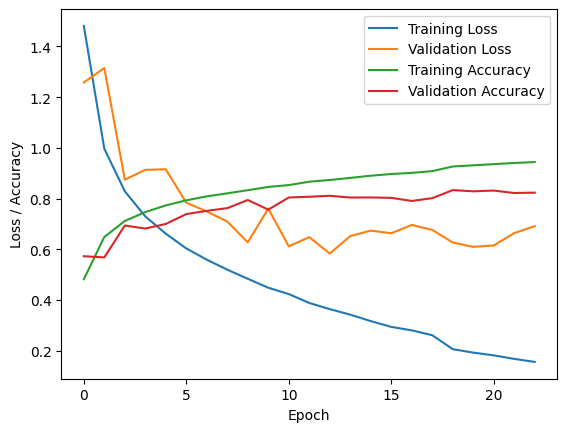

In [19]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()

## Pokus cislo 7

__Test accuracy: 0.721__\
__Test loss: 0.818__

In [33]:
wandb.init(project="neural-network-assgiment2")
wandb.run.name = "Pokus 7"
config = wandb.config
config.learning_rate = 0.001
config.batch_size = 32
config.epochs = 20

model = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])



optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=0.000001)

history = model.fit(X_train, y_train, epochs=config.epochs, batch_size=config.batch_size, validation_data=(X_val, y_val), callbacks=[lr_scheduler,early_stop,WandbCallback()])

# Evaluate the model
val_loss, val_acc = model.evaluate(X_test, y_test, verbose=2)
print('Test accuracy:', val_acc)
print('Test loss:', val_loss)

# Evaluate the model on the val set and log the results
wandb.log({'Test loss': val_loss, 'Test accuracy': val_acc})

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 batch_normalization_12 (Bat  (None, 30, 30, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 15, 15, 32)        0         
                                                                 
 conv2d_22 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 batch_normalization_13 (Bat  (None, 13, 13, 64)      

In [35]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()

## Pokus 8

__Test accuracy: 0.828__\
__Test loss: 0.8417__

In [36]:
import tensorflow as tf


# Define the model architecture
wandb.init(project="neural-network-assgiment2")
wandb.run.name = "Pokus 8"
config = wandb.config
config.learning_rate = 0.001
config.batch_size = 32
config.epochs = 20

# Define the residual block
def residual_block(inputs, filters, stride=1):
    shortcut = inputs

    x = tf.keras.layers.Conv2D(filters=filters, kernel_size=(3, 3), strides=stride, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters=filters, kernel_size=(3, 3), strides=1, padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Add the shortcut to the residual block output and apply ReLU activation
    if shortcut.shape[-1] != filters or stride != 1:
        shortcut = tf.keras.layers.Conv2D(filters=filters, kernel_size=(1, 1), strides=stride, padding='valid', activation='relu')(shortcut)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)

    x = tf.keras.layers.Add()([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)

    return x


# Define the model architecture with residual blocks
inputs = tf.keras.layers.Input(shape=(32, 32, 3))

x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = residual_block(x, filters=64)

x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = residual_block(x, filters=128)

x = tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = residual_block(x, filters=256)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(units=10, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=0.000001)

history = model.fit(X_train, y_train, epochs=config.epochs, batch_size=config.batch_size, validation_data=(X_val, y_val), callbacks=[lr_scheduler,early_stop,WandbCallback()])

# Evaluate the model
val_loss, val_acc = model.evaluate(X_test, y_test, verbose=2)
print('Test accuracy:', val_acc)
print('Test loss:', val_loss)

# Evaluate the model on the val set and log the results
wandb.log({'Test loss': val_loss, 'Test accuracy': val_acc})

In [24]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_24 (Conv2D)             (None, 32, 32, 64)   1792        ['input_2[0][0]']                
                                                                                                  
 batch_normalization_15 (BatchN  (None, 32, 32, 64)  256         ['conv2d_24[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 16, 16, 64)  0           ['batch_normalization_15[0]

In [38]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()

## Pokus 9
  
__Test accuracy: 0.8316__\
__Test loss: 0.5235__

- viac epoch

__Test accuracy: 0.866__\
__Test loss: 0.4276__

In [20]:
# Define the model architecture
wandb.init(project="neural-network-assgiment2")
wandb.run.name = "Pokus 9"
config = wandb.config
config.learning_rate = 0.001
config.batch_size = 64
config.epochs = 20

# Define the model architecture
model = tf.keras.Sequential()

# Add convolutional layers
model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.4))

# Add dense layers
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=0.000001)

history = model.fit(X_train, y_train, epochs=config.epochs, batch_size=config.batch_size, validation_data=(X_val, y_val), callbacks=[lr_scheduler,early_stop,WandbCallback()])

# Evaluate the model
val_loss, val_acc = model.evaluate(X_test, y_test, verbose=2)
print('Test accuracy:', val_acc)
print('Test loss:', val_loss)

# Evaluate the model on the val set and log the results
wandb.log({'Test loss': val_loss, 'Test accuracy': val_acc})

Test accuracy,▁
Test loss,▁
accuracy,▁▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█████
epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
loss,█▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
lr,██████████████████▁▁▁▁▁
val_accuracy,▁▁▄▄▄▆▆▆▇▆▇▇▇▇▇▇▇▇█████
val_loss,▇█▄▄▄▃▃▂▁▃▁▂▁▂▂▂▂▂▁▁▁▂▂
Test accuracy,0.8422
Test loss,0.59594
accuracy,0.94434


Epoch 1/40
781/782 [============================>.] - ETA: 0s - loss: 1.6128 - accuracy: 0.4500

INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230413_110638-djymcad9\files\model-best\assets


INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230413_110638-djymcad9\files\model-best\assets
wandb: Adding directory to artifact (D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230413_110638-djymcad9\files\model-best)... Done. 0.0s


782/782 [==============================] - 126s 158ms/step - loss: 1.6126 - accuracy: 0.4501 - val_loss: 1.2595 - val_accuracy: 0.5640 - lr: 0.0010
Epoch 2/40
782/782 [==============================] - ETA: 0s - loss: 1.0306 - accuracy: 0.6376

INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230413_110638-djymcad9\files\model-best\assets


INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230413_110638-djymcad9\files\model-best\assets
wandb: Adding directory to artifact (D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230413_110638-djymcad9\files\model-best)... Done. 0.0s


782/782 [==============================] - 127s 162ms/step - loss: 1.0306 - accuracy: 0.6376 - val_loss: 0.8962 - val_accuracy: 0.6896 - lr: 0.0010
Epoch 3/40
782/782 [==============================] - 119s 152ms/step - loss: 0.8695 - accuracy: 0.6953 - val_loss: 1.1081 - val_accuracy: 0.6456 - lr: 0.0010
Epoch 4/40
781/782 [============================>.] - ETA: 0s - loss: 0.7744 - accuracy: 0.7307

INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230413_110638-djymcad9\files\model-best\assets


INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230413_110638-djymcad9\files\model-best\assets
wandb: Adding directory to artifact (D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230413_110638-djymcad9\files\model-best)... Done. 0.0s


782/782 [==============================] - 121s 155ms/step - loss: 0.7746 - accuracy: 0.7306 - val_loss: 0.7995 - val_accuracy: 0.7214 - lr: 0.0010
Epoch 5/40
781/782 [============================>.] - ETA: 0s - loss: 0.7031 - accuracy: 0.7567

INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230413_110638-djymcad9\files\model-best\assets


INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230413_110638-djymcad9\files\model-best\assets
wandb: Adding directory to artifact (D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230413_110638-djymcad9\files\model-best)... Done. 0.0s


782/782 [==============================] - 119s 153ms/step - loss: 0.7034 - accuracy: 0.7566 - val_loss: 0.6756 - val_accuracy: 0.7714 - lr: 0.0010
Epoch 6/40
782/782 [==============================] - 122s 156ms/step - loss: 0.6461 - accuracy: 0.7782 - val_loss: 0.7322 - val_accuracy: 0.7524 - lr: 0.0010
Epoch 7/40
782/782 [==============================] - ETA: 0s - loss: 0.5984 - accuracy: 0.7962

INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230413_110638-djymcad9\files\model-best\assets


INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230413_110638-djymcad9\files\model-best\assets
wandb: Adding directory to artifact (D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230413_110638-djymcad9\files\model-best)... Done. 0.0s


782/782 [==============================] - 122s 156ms/step - loss: 0.5984 - accuracy: 0.7962 - val_loss: 0.6135 - val_accuracy: 0.7892 - lr: 0.0010
Epoch 8/40
782/782 [==============================] - 117s 149ms/step - loss: 0.5674 - accuracy: 0.8051 - val_loss: 0.6723 - val_accuracy: 0.7730 - lr: 0.0010
Epoch 9/40
781/782 [============================>.] - ETA: 0s - loss: 0.5343 - accuracy: 0.8176

INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230413_110638-djymcad9\files\model-best\assets


INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230413_110638-djymcad9\files\model-best\assets
wandb: Adding directory to artifact (D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230413_110638-djymcad9\files\model-best)... Done. 0.0s


782/782 [==============================] - 120s 153ms/step - loss: 0.5344 - accuracy: 0.8176 - val_loss: 0.5811 - val_accuracy: 0.8020 - lr: 0.0010
Epoch 10/40
782/782 [==============================] - 120s 153ms/step - loss: 0.4988 - accuracy: 0.8295 - val_loss: 0.6482 - val_accuracy: 0.7864 - lr: 0.0010
Epoch 11/40
782/782 [==============================] - ETA: 0s - loss: 0.4709 - accuracy: 0.8392

INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230413_110638-djymcad9\files\model-best\assets


INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230413_110638-djymcad9\files\model-best\assets
wandb: Adding directory to artifact (D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230413_110638-djymcad9\files\model-best)... Done. 0.0s


782/782 [==============================] - 124s 158ms/step - loss: 0.4709 - accuracy: 0.8392 - val_loss: 0.5237 - val_accuracy: 0.8192 - lr: 0.0010
Epoch 12/40
782/782 [==============================] - 117s 150ms/step - loss: 0.4493 - accuracy: 0.8474 - val_loss: 0.6087 - val_accuracy: 0.7978 - lr: 0.0010
Epoch 13/40
782/782 [==============================] - 117s 150ms/step - loss: 0.4311 - accuracy: 0.8527 - val_loss: 0.5763 - val_accuracy: 0.8146 - lr: 0.0010
Epoch 14/40
782/782 [==============================] - 117s 149ms/step - loss: 0.4126 - accuracy: 0.8592 - val_loss: 0.6190 - val_accuracy: 0.7998 - lr: 0.0010
Epoch 15/40
782/782 [==============================] - 116s 149ms/step - loss: 0.4018 - accuracy: 0.8621 - val_loss: 0.5675 - val_accuracy: 0.8142 - lr: 0.0010
Epoch 16/40
782/782 [==============================] - ETA: 0s - loss: 0.3805 - accuracy: 0.8687

INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230413_110638-djymcad9\files\model-best\assets


INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230413_110638-djymcad9\files\model-best\assets
wandb: Adding directory to artifact (D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230413_110638-djymcad9\files\model-best)... Done. 0.0s


782/782 [==============================] - 119s 152ms/step - loss: 0.3805 - accuracy: 0.8687 - val_loss: 0.4942 - val_accuracy: 0.8432 - lr: 0.0010
Epoch 17/40
782/782 [==============================] - 116s 149ms/step - loss: 0.3766 - accuracy: 0.8705 - val_loss: 0.5146 - val_accuracy: 0.8322 - lr: 0.0010
Epoch 18/40
782/782 [==============================] - 118s 151ms/step - loss: 0.3612 - accuracy: 0.8753 - val_loss: 0.4966 - val_accuracy: 0.8354 - lr: 0.0010
Epoch 19/40
782/782 [==============================] - 122s 156ms/step - loss: 0.3510 - accuracy: 0.8783 - val_loss: 0.5194 - val_accuracy: 0.8314 - lr: 0.0010
Epoch 20/40
782/782 [==============================] - 119s 152ms/step - loss: 0.3418 - accuracy: 0.8820 - val_loss: 0.5048 - val_accuracy: 0.8356 - lr: 0.0010
Epoch 21/40
782/782 [==============================] - 119s 152ms/step - loss: 0.3310 - accuracy: 0.8835 - val_loss: 0.5367 - val_accuracy: 0.8314 - lr: 0.0010
Epoch 22/40
782/782 [==============================]

INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230413_110638-djymcad9\files\model-best\assets


INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230413_110638-djymcad9\files\model-best\assets
wandb: Adding directory to artifact (D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230413_110638-djymcad9\files\model-best)... Done. 0.0s


782/782 [==============================] - 120s 154ms/step - loss: 0.3000 - accuracy: 0.8969 - val_loss: 0.4500 - val_accuracy: 0.8556 - lr: 8.0000e-04
Epoch 23/40
782/782 [==============================] - 120s 153ms/step - loss: 0.2890 - accuracy: 0.8995 - val_loss: 0.4842 - val_accuracy: 0.8494 - lr: 8.0000e-04
Epoch 24/40
782/782 [==============================] - 121s 155ms/step - loss: 0.2819 - accuracy: 0.9016 - val_loss: 0.4822 - val_accuracy: 0.8500 - lr: 8.0000e-04
Epoch 25/40
782/782 [==============================] - 120s 154ms/step - loss: 0.2717 - accuracy: 0.9041 - val_loss: 0.4574 - val_accuracy: 0.8536 - lr: 8.0000e-04
Epoch 26/40
782/782 [==============================] - 122s 156ms/step - loss: 0.2624 - accuracy: 0.9084 - val_loss: 0.4556 - val_accuracy: 0.8578 - lr: 8.0000e-04
Epoch 27/40
782/782 [==============================] - 121s 154ms/step - loss: 0.2552 - accuracy: 0.9119 - val_loss: 0.4843 - val_accuracy: 0.8540 - lr: 8.0000e-04
Epoch 28/40
782/782 [=======

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_12 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_23 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_13 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                        

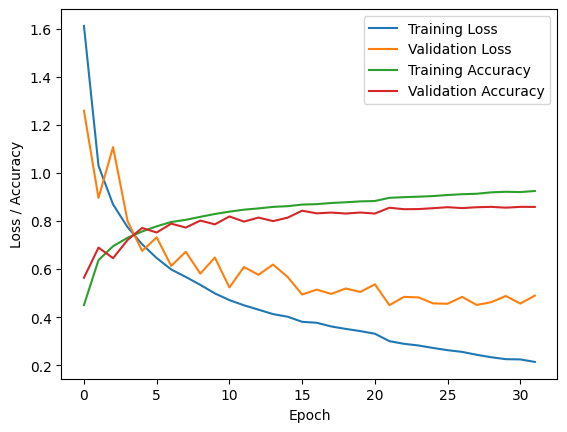

In [22]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()

# Pokus cislo 10

__Test accuracy: 0.8178__\
__Test loss: 0.5547__

In [ ]:
import tensorflow as tf

# Define the model architecture
wandb.init(project="neural-network-assgiment2")
wandb.run.name = "Pokus 10"
config = wandb.config
config.learning_rate = 0.001
config.batch_size = 64
config.epochs = 20

# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(filters=32, kernel_size=5, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=32, kernel_size=5, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=32, kernel_size=5, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=32, kernel_size=5, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(filters=128, kernel_size=7, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=128, kernel_size=7, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=128, kernel_size=7, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=128, kernel_size=7, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10, activation='softmax')
])


optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=0.000001)

history = model.fit(X_train, y_train, epochs=config.epochs, batch_size=config.batch_size, validation_data=(X_val, y_val), callbacks=[lr_scheduler,early_stop,WandbCallback()])

# Evaluate the model
val_loss, val_acc = model.evaluate(X_test, y_test, verbose=2)
print('Test accuracy:', val_acc)
print('Test loss:', val_loss)

# Evaluate the model on the val set and log the results
wandb.log({'Test loss': val_loss, 'Test accuracy': val_acc})


782/782 [==============================] - ETA: 0s - loss: 0.6573 - accuracy: 0.7805

INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_194235-vahfuawd\files\model-best\assets


INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_194235-vahfuawd\files\model-best\assets
wandb: Adding directory to artifact (D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_194235-vahfuawd\files\model-best)... Done. 0.1s


782/782 [==============================] - 2037s 3s/step - loss: 0.6573 - accuracy: 0.7805 - val_loss: 0.7736 - val_accuracy: 0.7306 - lr: 0.0010
Epoch 11/20
782/782 [==============================] - ETA: 0s - loss: 0.6328 - accuracy: 0.7890

INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_194235-vahfuawd\files\model-best\assets


INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_194235-vahfuawd\files\model-best\assets
wandb: Adding directory to artifact (D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_194235-vahfuawd\files\model-best)... Done. 0.1s


782/782 [==============================] - 471s 602ms/step - loss: 0.6328 - accuracy: 0.7890 - val_loss: 0.6878 - val_accuracy: 0.7606 - lr: 0.0010
Epoch 12/20
265/782 [=========>....................] - ETA: 4:51 - loss: 0.5990 - accuracy: 0.7995

In [28]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 32, 32, 16)        448       
                                                                 
 batch_normalization_32 (Bat  (None, 32, 32, 16)       64        
 chNormalization)                                                
                                                                 
 conv2d_46 (Conv2D)          (None, 32, 32, 16)        2320      
                                                                 
 batch_normalization_33 (Bat  (None, 32, 32, 16)       64        
 chNormalization)                                                
                                                                 
 conv2d_47 (Conv2D)          (None, 32, 32, 16)        2320      
                                                                 
 batch_normalization_34 (Bat  (None, 32, 32, 16)      

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()

# Pokus cislo 11

__Test accuracy: 0.7222__\
__Test loss: 1.2__

In [15]:
import tensorflow as tf

# Define the model architecture
wandb.init(project="neural-network-assgiment2")
wandb.run.name = "Pokus 11"
config = wandb.config
config.learning_rate = 0.001
config.batch_size = 32
config.epochs = 20

# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=10, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=0.000001)

history = model.fit(X_train, y_train, epochs=config.epochs, batch_size=config.batch_size, validation_data=(X_val, y_val), callbacks=[lr_scheduler,early_stop,WandbCallback()])

# Evaluate the model
val_loss, val_acc = model.evaluate(X_test, y_test, verbose=2)
print('Test accuracy:', val_acc)
print('Test loss:', val_loss)

# Evaluate the model on the val set and log the results
wandb.log({'Test loss': val_loss, 'Test accuracy': val_acc})

wandb: Currently logged in as: andrejbelak0 (neural-netwok-nn). Use `wandb login --relogin` to force relogin


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/20
1561/1563 [============================>.] - ETA: 0s - loss: 1.5134 - accuracy: 0.4691

INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_224138-4rzaymfy\files\model-best\assets


INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_224138-4rzaymfy\files\model-best\assets
wandb: Adding directory to artifact (D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_224138-4rzaymfy\files\model-best)... Done. 0.0s


1563/1563 [==============================] - 32s 19ms/step - loss: 1.5132 - accuracy: 0.4692 - val_loss: 1.3608 - val_accuracy: 0.5246 - lr: 0.0010
Epoch 2/20
1561/1563 [============================>.] - ETA: 0s - loss: 1.1229 - accuracy: 0.6028

INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_224138-4rzaymfy\files\model-best\assets


INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_224138-4rzaymfy\files\model-best\assets
wandb: Adding directory to artifact (D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_224138-4rzaymfy\files\model-best)... Done. 0.0s


1563/1563 [==============================] - 30s 19ms/step - loss: 1.1226 - accuracy: 0.6029 - val_loss: 1.1787 - val_accuracy: 0.5830 - lr: 0.0010
Epoch 3/20
1561/1563 [============================>.] - ETA: 0s - loss: 0.9445 - accuracy: 0.6660

INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_224138-4rzaymfy\files\model-best\assets


INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_224138-4rzaymfy\files\model-best\assets
wandb: Adding directory to artifact (D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_224138-4rzaymfy\files\model-best)... Done. 0.0s


1563/1563 [==============================] - 30s 19ms/step - loss: 0.9444 - accuracy: 0.6660 - val_loss: 1.0916 - val_accuracy: 0.6318 - lr: 0.0010
Epoch 4/20
1561/1563 [============================>.] - ETA: 0s - loss: 0.8107 - accuracy: 0.7153

INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_224138-4rzaymfy\files\model-best\assets


INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_224138-4rzaymfy\files\model-best\assets
wandb: Adding directory to artifact (D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_224138-4rzaymfy\files\model-best)... Done. 0.0s


1563/1563 [==============================] - 31s 20ms/step - loss: 0.8106 - accuracy: 0.7153 - val_loss: 0.9744 - val_accuracy: 0.6718 - lr: 0.0010
Epoch 5/20
1560/1563 [============================>.] - ETA: 0s - loss: 0.7095 - accuracy: 0.7501

INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_224138-4rzaymfy\files\model-best\assets


INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_224138-4rzaymfy\files\model-best\assets
wandb: Adding directory to artifact (D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_224138-4rzaymfy\files\model-best)... Done. 0.0s


1563/1563 [==============================] - 31s 20ms/step - loss: 0.7093 - accuracy: 0.7501 - val_loss: 0.9365 - val_accuracy: 0.6862 - lr: 0.0010
Epoch 6/20
1560/1563 [============================>.] - ETA: 0s - loss: 0.6117 - accuracy: 0.7833

INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_224138-4rzaymfy\files\model-best\assets


INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_224138-4rzaymfy\files\model-best\assets
wandb: Adding directory to artifact (D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_224138-4rzaymfy\files\model-best)... Done. 0.0s


1563/1563 [==============================] - 31s 20ms/step - loss: 0.6119 - accuracy: 0.7833 - val_loss: 0.9010 - val_accuracy: 0.7118 - lr: 0.0010
Epoch 7/20
1563/1563 [==============================] - 29s 19ms/step - loss: 0.5321 - accuracy: 0.8120 - val_loss: 0.9645 - val_accuracy: 0.6894 - lr: 0.0010
Epoch 8/20
1563/1563 [==============================] - 30s 19ms/step - loss: 0.4609 - accuracy: 0.8358 - val_loss: 1.0105 - val_accuracy: 0.6850 - lr: 0.0010
Epoch 9/20
1563/1563 [==============================] - 30s 19ms/step - loss: 0.4034 - accuracy: 0.8585 - val_loss: 1.0805 - val_accuracy: 0.6892 - lr: 0.0010
Epoch 10/20
1563/1563 [==============================] - 32s 20ms/step - loss: 0.3499 - accuracy: 0.8757 - val_loss: 1.0843 - val_accuracy: 0.6954 - lr: 0.0010
Epoch 11/20
1563/1563 [==============================] - 28s 18ms/step - loss: 0.3154 - accuracy: 0.8884 - val_loss: 1.1607 - val_accuracy: 0.6832 - lr: 0.0010
Epoch 12/20
1563/1563 [==============================] 

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 64)         256       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          3

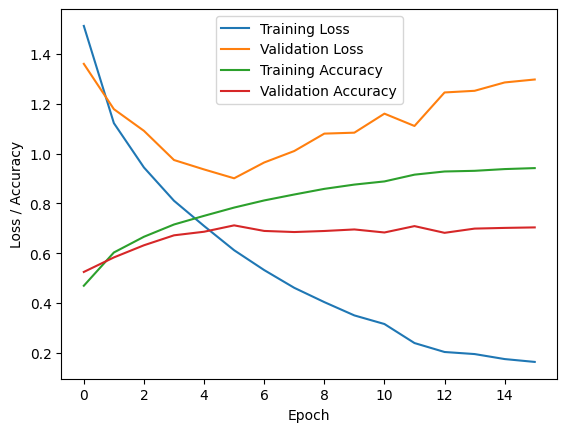

In [17]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()

# Pokus 12

__Test accuracy: 0.762__\
__Test loss: 0.7438__

In [18]:
import tensorflow as tf

# Define the model architecture
wandb.init(project="neural-network-assgiment2")
wandb.run.name = "Pokus 12"
config = wandb.config
config.learning_rate = 0.001
config.batch_size = 64
config.epochs = 20

# Define the model architecture
model = tf.keras.models.Sequential([
    # First Convolutional layer
    tf.keras.layers.Conv2D(32, (3, 3), strides=(2,2), activation='relu', input_shape=(32, 32, 3), padding='same'),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),

    # Second Convolutional layer
    tf.keras.layers.Conv2D(64, (3, 3), strides=(2,2), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),

    # Third Convolutional layer
    tf.keras.layers.Conv2D(128, (3, 3), strides=(2,2), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),

    # Flatten the output from the convolutional layers
    tf.keras.layers.Flatten(),

    # Dense layer
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.25),

    # Output layer
    tf.keras.layers.Dense(10, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=0.000001)

history = model.fit(X_train, y_train, epochs=config.epochs, batch_size=config.batch_size, validation_data=(X_val, y_val), callbacks=[lr_scheduler,early_stop,WandbCallback()])

# Evaluate the model
val_loss, val_acc = model.evaluate(X_test, y_test, verbose=2)
print('Test accuracy:', val_acc)
print('Test loss:', val_loss)

# Evaluate the model on the val set and log the results
wandb.log({'Test loss': val_loss, 'Test accuracy': val_acc})

Test accuracy,▁
Test loss,▁
accuracy,▁▃▄▅▅▆▆▆▇▇▇█████
epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
loss,█▆▅▄▄▃▃▃▂▂▂▁▁▁▁▁
lr,███████████▁▁▁▁▁
val_accuracy,▁▃▅▇▇█▇▇▇▇▇█▇███
val_loss,█▅▄▂▂▁▂▃▄▄▅▄▆▆▇▇
Test accuracy,0.7222
Test loss,1.20007
accuracy,0.9419


Epoch 1/20
781/782 [============================>.] - ETA: 0s - loss: 1.8277 - accuracy: 0.3285

INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_224936-kp1fom2z\files\model-best\assets


INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_224936-kp1fom2z\files\model-best\assets
wandb: Adding directory to artifact (D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_224936-kp1fom2z\files\model-best)... Done. 0.0s


782/782 [==============================] - 46s 56ms/step - loss: 1.8276 - accuracy: 0.3285 - val_loss: 1.5540 - val_accuracy: 0.4324 - lr: 0.0010
Epoch 2/20
782/782 [==============================] - 47s 60ms/step - loss: 1.4397 - accuracy: 0.4814 - val_loss: 1.8685 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 3/20
781/782 [============================>.] - ETA: 0s - loss: 1.2665 - accuracy: 0.5494

INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_224936-kp1fom2z\files\model-best\assets


INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_224936-kp1fom2z\files\model-best\assets
wandb: Adding directory to artifact (D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_224936-kp1fom2z\files\model-best)... Done. 0.0s


782/782 [==============================] - 45s 58ms/step - loss: 1.2665 - accuracy: 0.5494 - val_loss: 1.2111 - val_accuracy: 0.5754 - lr: 0.0010
Epoch 4/20
781/782 [============================>.] - ETA: 0s - loss: 1.1560 - accuracy: 0.5959

INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_224936-kp1fom2z\files\model-best\assets


INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_224936-kp1fom2z\files\model-best\assets
wandb: Adding directory to artifact (D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_224936-kp1fom2z\files\model-best)... Done. 0.0s


782/782 [==============================] - 44s 57ms/step - loss: 1.1562 - accuracy: 0.5959 - val_loss: 1.1701 - val_accuracy: 0.5914 - lr: 0.0010
Epoch 5/20
781/782 [============================>.] - ETA: 0s - loss: 1.0652 - accuracy: 0.6321

INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_224936-kp1fom2z\files\model-best\assets


INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_224936-kp1fom2z\files\model-best\assets
wandb: Adding directory to artifact (D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_224936-kp1fom2z\files\model-best)... Done. 0.0s


782/782 [==============================] - 46s 59ms/step - loss: 1.0652 - accuracy: 0.6321 - val_loss: 1.1558 - val_accuracy: 0.6066 - lr: 0.0010
Epoch 6/20
782/782 [==============================] - ETA: 0s - loss: 0.9900 - accuracy: 0.6577

INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_224936-kp1fom2z\files\model-best\assets


INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_224936-kp1fom2z\files\model-best\assets
wandb: Adding directory to artifact (D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_224936-kp1fom2z\files\model-best)... Done. 0.0s


782/782 [==============================] - 44s 56ms/step - loss: 0.9900 - accuracy: 0.6577 - val_loss: 1.0634 - val_accuracy: 0.6412 - lr: 0.0010
Epoch 7/20
782/782 [==============================] - 40s 51ms/step - loss: 0.9314 - accuracy: 0.6805 - val_loss: 1.1086 - val_accuracy: 0.6120 - lr: 0.0010
Epoch 8/20
782/782 [==============================] - 40s 51ms/step - loss: 0.8791 - accuracy: 0.6999 - val_loss: 1.1207 - val_accuracy: 0.6122 - lr: 0.0010
Epoch 9/20
781/782 [============================>.] - ETA: 0s - loss: 0.8286 - accuracy: 0.7160

INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_224936-kp1fom2z\files\model-best\assets


INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_224936-kp1fom2z\files\model-best\assets
wandb: Adding directory to artifact (D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_224936-kp1fom2z\files\model-best)... Done. 0.0s


782/782 [==============================] - 43s 55ms/step - loss: 0.8286 - accuracy: 0.7160 - val_loss: 0.8703 - val_accuracy: 0.7062 - lr: 0.0010
Epoch 10/20
782/782 [==============================] - 39s 50ms/step - loss: 0.7882 - accuracy: 0.7315 - val_loss: 0.8750 - val_accuracy: 0.7040 - lr: 0.0010
Epoch 11/20
781/782 [============================>.] - ETA: 0s - loss: 0.7494 - accuracy: 0.7447

INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_224936-kp1fom2z\files\model-best\assets


INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_224936-kp1fom2z\files\model-best\assets
wandb: Adding directory to artifact (D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_224936-kp1fom2z\files\model-best)... Done. 0.0s


782/782 [==============================] - 43s 55ms/step - loss: 0.7494 - accuracy: 0.7447 - val_loss: 0.8566 - val_accuracy: 0.6954 - lr: 0.0010
Epoch 12/20
782/782 [==============================] - 39s 50ms/step - loss: 0.7164 - accuracy: 0.7572 - val_loss: 0.9091 - val_accuracy: 0.6980 - lr: 0.0010
Epoch 13/20
781/782 [============================>.] - ETA: 0s - loss: 0.6920 - accuracy: 0.7639

INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_224936-kp1fom2z\files\model-best\assets


INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_224936-kp1fom2z\files\model-best\assets
wandb: Adding directory to artifact (D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_224936-kp1fom2z\files\model-best)... Done. 0.0s


782/782 [==============================] - 42s 53ms/step - loss: 0.6921 - accuracy: 0.7638 - val_loss: 0.8490 - val_accuracy: 0.7148 - lr: 0.0010
Epoch 14/20
782/782 [==============================] - 39s 49ms/step - loss: 0.6615 - accuracy: 0.7745 - val_loss: 1.1559 - val_accuracy: 0.6494 - lr: 0.0010
Epoch 15/20
782/782 [==============================] - 39s 50ms/step - loss: 0.6349 - accuracy: 0.7811 - val_loss: 0.9851 - val_accuracy: 0.6888 - lr: 0.0010
Epoch 16/20
781/782 [============================>.] - ETA: 0s - loss: 0.6156 - accuracy: 0.7885

INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_224936-kp1fom2z\files\model-best\assets


INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_224936-kp1fom2z\files\model-best\assets
wandb: Adding directory to artifact (D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_224936-kp1fom2z\files\model-best)... Done. 0.0s


782/782 [==============================] - 45s 57ms/step - loss: 0.6156 - accuracy: 0.7884 - val_loss: 0.8257 - val_accuracy: 0.7298 - lr: 0.0010
Epoch 17/20
782/782 [==============================] - 41s 52ms/step - loss: 0.5902 - accuracy: 0.7984 - val_loss: 0.8374 - val_accuracy: 0.7254 - lr: 0.0010
Epoch 18/20
782/782 [==============================] - 40s 52ms/step - loss: 0.5705 - accuracy: 0.8049 - val_loss: 0.9022 - val_accuracy: 0.7080 - lr: 0.0010
Epoch 19/20
782/782 [==============================] - 40s 51ms/step - loss: 0.5548 - accuracy: 0.8112 - val_loss: 0.8259 - val_accuracy: 0.7392 - lr: 0.0010
Epoch 20/20
781/782 [============================>.] - ETA: 0s - loss: 0.5353 - accuracy: 0.8182

INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_224936-kp1fom2z\files\model-best\assets


INFO:tensorflow:Assets written to: D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_224936-kp1fom2z\files\model-best\assets
wandb: Adding directory to artifact (D:\10.semester\NN\neural-networks\2.zadanie\src\wandb\run-20230412_224936-kp1fom2z\files\model-best)... Done. 0.0s


782/782 [==============================] - 45s 58ms/step - loss: 0.5353 - accuracy: 0.8182 - val_loss: 0.8128 - val_accuracy: 0.7430 - lr: 0.0010
157/157 - 1s - loss: 0.7438 - accuracy: 0.7620 - 1s/epoch - 8ms/step
Test accuracy: 0.7620000243186951
Test loss: 0.7438197731971741


In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 16, 16, 32)        896       
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 batch_normalization_4 (Batc  (None, 16, 16, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 32)         0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 32)         

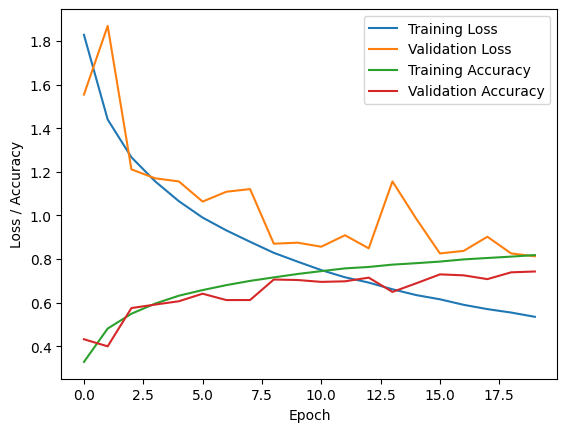

In [20]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()

#### Augmentovany a normalizovany dataset

In [ ]:
(X_train, y_train), (X_val, y_val) = cifar10.load_data()

X_train = dataNormalisation(X_train)
X_val = dataNormalisation(X_val)

X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=25)

Augmentacia dat, zvysenie poctu obrazkov o dvojnasobok

In [ ]:
# Define the data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1)

# Generate augmented images and labels
augmented_images = []
augmented_labels = []
for i in range(X_train.shape[0]):
    # Generate augmented image
    augmented_image = datagen.random_transform(X_train[i])
    # Append augmented image to list of augmented images
    augmented_images.append(augmented_image)
    # Append corresponding label to list of augmented labels
    augmented_labels.append(y_train[i])

# Convert the list of augmented images and labels to numpy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Concatenate original images and labels with augmented images and labels
X_train = np.concatenate((X_train, augmented_images))
y_train = np.concatenate((y_train, augmented_labels))

# Plot the original and augmented images
fig, axes = plt.subplots(5, 2, figsize=(8, 20))
for i in range(5):
    # Plot the original image
    axes[i, 0].imshow(X_train[i])
    axes[i, 0].set_title(f"Original image (class {y_train[i][0]})")

    # Plot the augmented image
    axes[i, 1].imshow(augmented_images[i])
    axes[i, 1].set_title("Augmented image")
plt.show()

In [ ]:
print(X_train.shape)
print(y_train.shape)

In [ ]:
# one hot encoding
y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
model = keras.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

test_loss, test_acc = model.evaluate(X_test, y_test)

In [ ]:
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()